In [1]:
import cv2
from os import path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
# import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from keras.layers import Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

import wandb


wandb.login()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


wandb: Currently logged in as: camperko (use `wandb login --relogin` to force relogin)


True

In [13]:
labels = pd.read_csv('data/train.csv')
labels.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [14]:
categories = []
for index, row in labels.iterrows():
    parts = row['labels'].split(' ')
    for part in parts:
        if part not in categories:
            categories.append(part)

category_dict = {}
for category in categories:
    labels[category] = np.zeros(labels.shape[0])
    category_dict[category] = 0

for index, row in labels.iterrows():
    parts = row['labels'].split(' ')
    for part in parts:
        labels[part][index] = 1
        category_dict[part] += 1

labels = labels.drop(['labels'], axis=1)

<ipython-input-14-6b7e234d1804>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[part][index] = 1


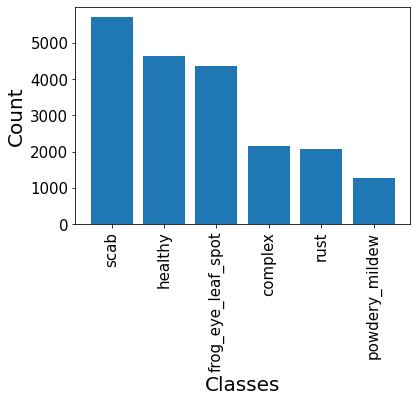

In [15]:
cat_dict = dict(sorted(category_dict.items(), key=lambda item: item[1], reverse=True))

classes_labels = cat_dict.keys()
classes_counts = cat_dict.values()

plt.bar(classes_labels, classes_counts)
plt.title('Class count')
plt.xlabel("Classes", fontsize=20)
plt.xticks(rotation=45,fontsize = 10)
plt.ylabel("Count", fontsize=20)
plt.yticks(fontsize = 10)
plt.show()

In [16]:
import hashlib
import os

def file_hash(path):
    with open(path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

duplicates = []
hash_set = []
new_labels = labels.copy()

for index, row in labels.iterrows():
    image = row['image']
    if path.exists('data/train_images/' + image):
        calc_hash = file_hash(os.getcwd() + '\\data\\train_images\\' + image)
        if calc_hash in hash_set:
            duplicate_index = hash_set.index(calc_hash)
            duplicates.append((duplicate_index, index))
        hash_set.append(calc_hash)

In [17]:
new_labels = labels.copy()
to_remove = []
for dup in duplicates:
    for category in categories:
        if labels[category][dup[1]] == 1:
            labels[category][dup[0]] = 1
    to_remove.append(dup[1])

to_remove.sort(reverse=True)

removed_images = []
for rem in to_remove:
    removed_images.append(labels['image'][rem])
    new_labels = new_labels.drop(index=rem)
    if path.exists('data/train_images/' + labels['image'][rem]):
        os.remove(os.getcwd() + '\\data\\train_images\\' + labels['image'][rem])

<ipython-input-17-3685820d68aa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[category][dup[0]] = 1


In [18]:
new_labels.to_csv('data/new_train.csv', index=False, encoding='utf-8')

In [3]:
new_labels = pd.read_csv('data/new_train.csv')
new_labels.head()

,image,healthy,scab,frog_eye_leaf_spot,complex,rust,powdery_mildew
0,800113bb65efe69e.jpg,1.0,0.0,0.0,0.0,0.0,0.0
1,8002cb321f8bfcdf.jpg,0.0,1.0,1.0,1.0,0.0,0.0
2,80070f7fb5e2ccaa.jpg,0.0,1.0,0.0,0.0,0.0,0.0
3,80077517781fb94f.jpg,0.0,1.0,0.0,0.0,0.0,0.0
4,800cbf0ff87721f8.jpg,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
complex_set = []
rust_set = []
powdery_set = []

for index, row in new_labels.iterrows():
    if row['healthy'] == 0 and row['scab'] == 0 and row['frog_eye_leaf_spot'] == 0:
        if row['complex'] == 1 and row['rust'] == 0 and row['powdery_mildew'] == 0:
            complex_set.append(row)
        if row['complex'] == 0 and row['rust'] == 1 and row['powdery_mildew'] == 0:
            rust_set.append(row)
        if row['complex'] == 0 and row['rust'] == 0 and row['powdery_mildew'] == 1:
            powdery_set.append(row)

In [5]:
config = {"lr": 1e-5,
          "num_epoch": 5,
          "size": 128,
          "optimizer": "adam",
          "net": "VGG11",
          "batch_size": 16}

In [5]:
# WARNING! run only one time
def resize_image(in_image, image_name):
    resized_image = cv2.resize(in_image, (config["size"], config["size"]), interpolation = cv2.INTER_AREA)
    cv2.imwrite('data/new_train_images_128/' + image_name, resized_image)

# for index, row in new_labels.iterrows():
#     if path.exists('data/train_images/' + row['image']):
#         resize_image(cv2.imread('data/train_images/' + row['image']), row['image'])

ERROR! Session/line number was not unique in database. History logging moved to new session 42


In [8]:
def normalize_image(in_image):
    in_image = in_image / 255
    return in_image

image_set = []
labels_set = []

for index, row in new_labels.iterrows():
    if path.exists('data/new_train_images_128/' + row['image']):
        image_normalized = normalize_image(cv2.imread('data/new_train_images_128/' + row['image']))
        image_set.append(image_normalized)
        labels_set.append(row)

In [7]:
for row in complex_set:
    new_image = normalize_image(cv2.imread('data/new_train_images_128/' + row['image']))
    for i in range(0, 2):
        flip_image = cv2.flip(new_image, i)
        image_set.append(flip_image)
        labels_set.append(row)

print('Complex set done')

for row in rust_set:
    new_image = normalize_image(cv2.imread('data/new_train_images_128/' + row['image']))
    for i in range(0, 2):
        flip_image = cv2.flip(new_image, i)
        image_set.append(flip_image)
        labels_set.append(row)

print('Rust set done')

for row in powdery_set:
    new_image = normalize_image(cv2.imread('data/new_train_images_128/' + row['image']))
    for i in range(-1, 2):
        flip_image = cv2.flip(new_image, i)
        image_set.append(flip_image)
        labels_set.append(row)

print('Powdery set done')

labels_set = pd.DataFrame(labels_set)


Complex set done
Rust set done
Powdery set done


In [33]:
# cv2.namedWindow("image", cv2.WINDOW_NORMAL)
# cv2.imshow("image", image_set[0])
# cv2.waitKey(0)

In [23]:
labels_clear_set = labels_set.drop(['image'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(image_set, labels_clear_set, test_size=0.2, random_state=5, shuffle=True, stratify=labels_clear_set)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=5, shuffle=True, stratify=y_test)


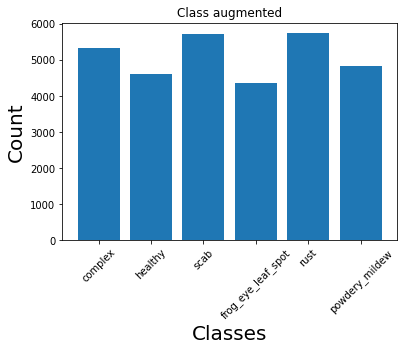

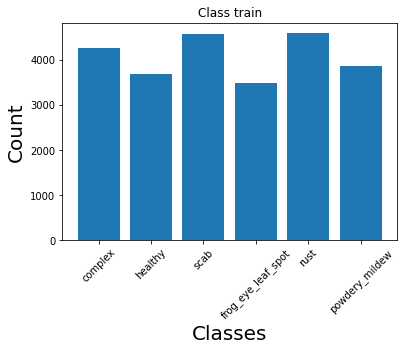

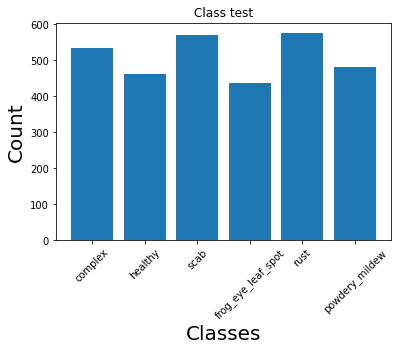

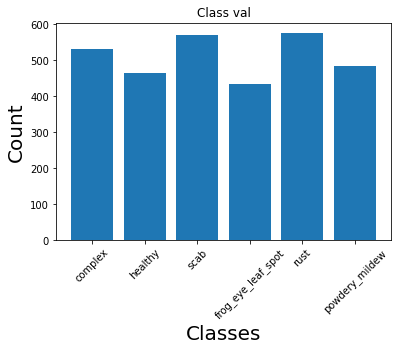

Complex:	5326	train:	4260	test:	534	val:	532
Healthy:	4624	train:	3699	test:	462	val:	463
Scab:		5712	train:	4570	test:	571	val:	571
Frog:		4352	train:	3482	test:	436	val:	434
Rust:		5747	train:	4597	test:	575	val:	575
Powdery:	4823	train:	3858	test:	482	val:	483


In [24]:
count_complex = labels_clear_set[labels_clear_set['complex'] == 1]
count_healthy = labels_clear_set[labels_clear_set['healthy'] == 1]
count_scab = labels_clear_set[labels_clear_set['scab'] == 1]
count_frog = labels_clear_set[labels_clear_set['frog_eye_leaf_spot'] == 1]
count_rust = labels_clear_set[labels_clear_set['rust'] == 1]
count_powdery = labels_clear_set[labels_clear_set['powdery_mildew'] == 1]

count_complex_train = y_train[y_train['complex'] == 1]
count_healthy_train = y_train[y_train['healthy'] == 1]
count_scab_train = y_train[y_train['scab'] == 1]
count_frog_train = y_train[y_train['frog_eye_leaf_spot'] == 1]
count_rust_train = y_train[y_train['rust'] == 1]
count_powdery_train = y_train[y_train['powdery_mildew'] == 1]

count_complex_test = y_test[y_test['complex'] == 1]
count_healthy_test = y_test[y_test['healthy'] == 1]
count_scab_test = y_test[y_test['scab'] == 1]
count_frog_test = y_test[y_test['frog_eye_leaf_spot'] == 1]
count_rust_test = y_test[y_test['rust'] == 1]
count_powdery_test = y_test[y_test['powdery_mildew'] == 1]

count_complex_val = y_val[y_val['complex'] == 1]
count_healthy_val = y_val[y_val['healthy'] == 1]
count_scab_val = y_val[y_val['scab'] == 1]
count_frog_val = y_val[y_val['frog_eye_leaf_spot'] == 1]
count_rust_val = y_val[y_val['rust'] == 1]
count_powdery_val = y_val[y_val['powdery_mildew'] == 1]

titles = ['complex', 'healthy', 'scab', 'frog_eye_leaf_spot', 'rust', 'powdery_mildew']
set_full = [count_complex.shape[0], count_healthy.shape[0], count_scab.shape[0], count_frog.shape[0], count_rust.shape[0], count_powdery.shape[0]]
set_train = [count_complex_train.shape[0], count_healthy_train.shape[0], count_scab_train.shape[0], count_frog_train.shape[0], count_rust_train.shape[0], count_powdery_train.shape[0]]
set_test = [count_complex_test.shape[0], count_healthy_test.shape[0], count_scab_test.shape[0], count_frog_test.shape[0], count_rust_test.shape[0], count_powdery_test.shape[0]]
set_val = [count_complex_val.shape[0], count_healthy_val.shape[0], count_scab_val.shape[0], count_frog_val.shape[0], count_rust_val.shape[0], count_powdery_val.shape[0]]

plt.bar(titles, set_full)
plt.title('Class augmented')
plt.xlabel("Classes", fontsize=20)
plt.xticks(rotation=45,fontsize = 10)
plt.ylabel("Count", fontsize=20)
plt.yticks(fontsize = 10)
plt.show()

plt.bar(titles, set_train)
plt.title('Class train')
plt.xlabel("Classes", fontsize=20)
plt.xticks(rotation=45,fontsize = 10)
plt.ylabel("Count", fontsize=20)
plt.yticks(fontsize = 10)
plt.show()

plt.bar(titles, set_test)
plt.title('Class test')
plt.xlabel("Classes", fontsize=20)
plt.xticks(rotation=45,fontsize = 10)
plt.ylabel("Count", fontsize=20)
plt.yticks(fontsize = 10)
plt.show()

plt.bar(titles, set_val)
plt.title('Class val')
plt.xlabel("Classes", fontsize=20)
plt.xticks(rotation=45,fontsize = 10)
plt.ylabel("Count", fontsize=20)
plt.yticks(fontsize = 10)
plt.show()

print('Complex:\t' + str(count_complex.shape[0]) + '\ttrain:\t' + str(count_complex_train.shape[0]) + '\ttest:\t' + str(count_complex_test.shape[0]) + '\tval:\t' + str(count_complex_val.shape[0]))
print('Healthy:\t' + str(count_healthy.shape[0]) + '\ttrain:\t' + str(count_healthy_train.shape[0]) + '\ttest:\t' + str(count_healthy_test.shape[0]) + '\tval:\t' + str(count_healthy_val.shape[0]))
print('Scab:\t\t' + str(count_scab.shape[0]) + '\ttrain:\t' + str(count_scab_train.shape[0]) + '\ttest:\t' + str(count_scab_test.shape[0]) + '\tval:\t' + str(count_scab_val.shape[0]))
print('Frog:\t\t' + str(count_frog.shape[0]) + '\ttrain:\t' + str(count_frog_train.shape[0]) + '\ttest:\t' + str(count_frog_test.shape[0]) + '\tval:\t' + str(count_frog_val.shape[0]))
print('Rust:\t\t' + str(count_rust.shape[0]) + '\ttrain:\t' + str(count_rust_train.shape[0]) + '\ttest:\t' + str(count_rust_test.shape[0]) + '\tval:\t' + str(count_rust_val.shape[0]))
print('Powdery:\t' + str(count_powdery.shape[0]) + '\ttrain:\t' + str(count_powdery_train.shape[0]) + '\ttest:\t' + str(count_powdery_test.shape[0]) + '\tval:\t' + str(count_powdery_val.shape[0]))

In [9]:
model = Sequential()

model.add(ZeroPadding2D((1, 1), input_shape=(config['size'], config['size'], 3)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
# model.add(ZeroPadding2D((1, 1)))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
# model.add(ZeroPadding2D((1, 1)))
# model.add(Conv2D(128, (3, 3)))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 130, 130, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 128)       0

In [12]:
run = wandb.init(project="plant-pathology")

wandb.config.update(config)

wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[
                  tf.keras.metrics.BinaryAccuracy(name='acc'),
                  tfa.metrics.F1Score(
                      num_classes=6,
                      average='macro'
                  )
              ])

history = model.fit(
    np.asarray(X_train),
    y_train,
    epochs=config['num_epoch'],
    validation_data=(np.asarray(X_test), y_test),
    batch_size=config['batch_size']
)


Epoch 1/5
1452/1452 [==============================] - 3386s 2s/step - loss: 0.4648 - accuracy: 0.1792 - val_loss: 0.4649 - val_accuracy: 0.1957

In [15]:
for loss in history.history['loss']:
    wandb.log({"loss": loss}, commit=True)

for accuracy in history.history['accuracy']:
    wandb.log({"accuracy": accuracy}, commit=True)

for val_loss in history.history['val_loss']:
    wandb.log({"val_loss": val_loss}, commit=True)

for val_accuracy in history.history['val_accuracy']:
    wandb.log({"val_accuracy": val_accuracy}, commit=True)


In [ ]:
pred = model.predict(np.asarray(X_val))

sum_positive = 0
for i in range(0, len(pred)):
    if pred[i][0] == y_val[i]['healthy'] and pred[i][1] == y_val[i]['scab'] and pred[i][2] == y_val[i]['frog_eye_leaf_spot']\
            and pred[i][3] == y_val[i]['complex'] and pred[i][4] == y_val[i]['rust'] and pred[i][5] == y_val[i]['powdery_mildew']:
        sum_positive += 1

print(sum_positive / len(pred))

In [ ]:
run.finish()